In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import SGD
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

+ Download dữ liệu CIFAR10 sau đó chia thành 2 tập dữ liệu train và validation.
+ Chuẩn hóa dữ liệu với mean = 0.5 và std = 0.5

In [9]:
import torch.utils
import torch.utils.data


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = (0.5, ), std = (0.5, ))])
trainset = torchvision.datasets.CIFAR10(root='CIFAR10', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=0, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='CIFAR10', train=True, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=0, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


+ Hiển thị 5 ảnh đầu tiên trong tập dữ liệu testing

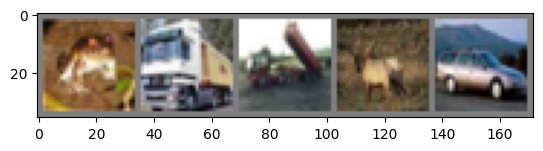

In [10]:
def imshow(img):
    img = img * 0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2,0 )))
    plt.show()

for i, (images, labels) in enumerate(testloader, 0):
  imshow(torchvision.utils.make_grid(images[:5]))
  break

+ Xây dựng model MLP cơ bản để train tập dữ liệu CIFAR10

In [11]:
def getModel(n_features):
  model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(n_features, 256),
      nn.ReLU(),
      nn.Linear(256, 10)
  ).to(device)
  return model



+ Khởi tạo hàm loss function và phương thức optimizer

In [12]:
n_features = 32*32*3
model = getModel(n_features)
lr = 0.01
optim = SGD(params = model.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

+ Xây dựng hàm đánh giá model

In [13]:
def evaluate(model, testloader, criterion):
  model.eval()
  test_loss = 0.0
  correct = 0
  total = 0
  for images, labels in testloader:
      images, labels = images.to(device), labels.to(device)


      outputs = model(images)
      loss = criterion(outputs, labels)
      test_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  test_loss = test_loss / len(testloader)
  return test_loss, accuracy


+ Bắt đầu training và đánh giá model.

In [14]:
n_epochs = 450
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = [0]
epoch = 0

while (epoch <= n_epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):

        inputs, labels = inputs.to(device), labels.to(device)

        optim.zero_grad() # khởi tạo giá trị đạo hàm = 0


        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()


        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # 2 dòng dưới đây là lan truyền ngược và optimizer tham số w và b.
        loss.backward()
        optim.step()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, loss_fn)
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    epoch += 1

Epoch [1/450], Loss: 2.2232, Accuracy: 20.40%, Test Loss: 2.1489, Test Accuracy: 25.42%
Epoch [2/450], Loss: 2.1026, Accuracy: 27.14%, Test Loss: 2.0601, Test Accuracy: 28.64%
Epoch [3/450], Loss: 2.0288, Accuracy: 29.71%, Test Loss: 1.9978, Test Accuracy: 31.07%
Epoch [4/450], Loss: 1.9739, Accuracy: 31.88%, Test Loss: 1.9494, Test Accuracy: 32.61%
Epoch [5/450], Loss: 1.9302, Accuracy: 33.36%, Test Loss: 1.9103, Test Accuracy: 34.19%
Epoch [6/450], Loss: 1.8949, Accuracy: 34.65%, Test Loss: 1.8781, Test Accuracy: 35.18%
Epoch [7/450], Loss: 1.8653, Accuracy: 35.67%, Test Loss: 1.8511, Test Accuracy: 36.13%
Epoch [8/450], Loss: 1.8401, Accuracy: 36.43%, Test Loss: 1.8279, Test Accuracy: 36.92%
Epoch [9/450], Loss: 1.8187, Accuracy: 37.28%, Test Loss: 1.8078, Test Accuracy: 37.52%
Epoch [10/450], Loss: 1.7997, Accuracy: 37.66%, Test Loss: 1.7900, Test Accuracy: 38.14%
Epoch [11/450], Loss: 1.7831, Accuracy: 38.25%, Test Loss: 1.7740, Test Accuracy: 38.56%
Epoch [12/450], Loss: 1.7676, 

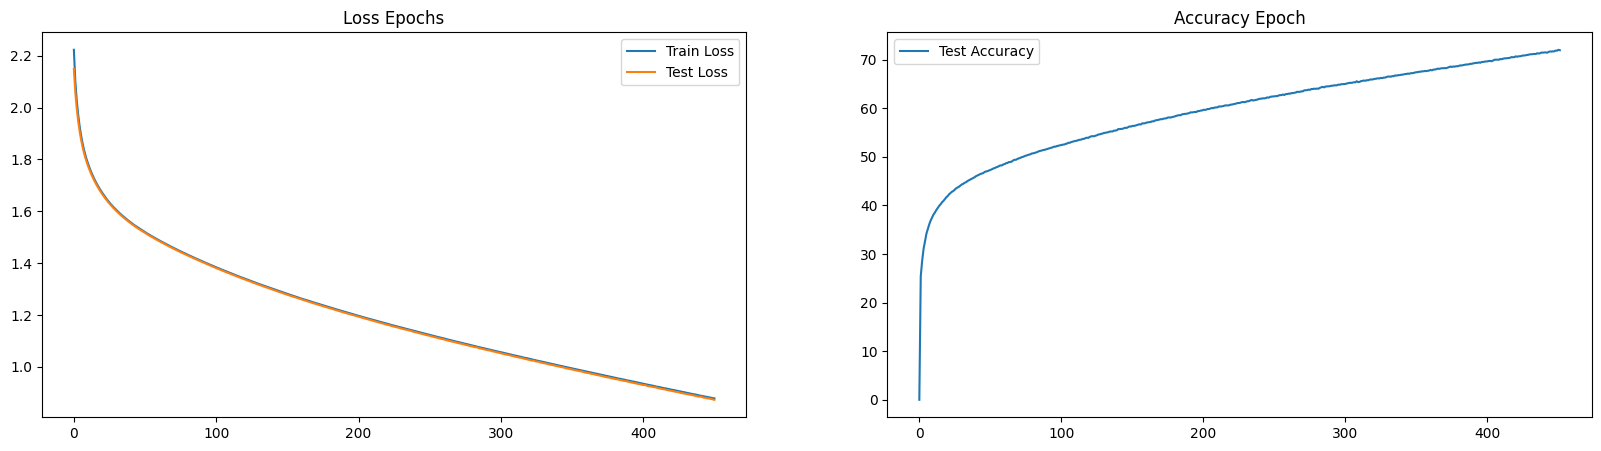

In [15]:
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracies, label = 'Test Accuracy')
plt.legend()

+ Dưới đây là bài tập về code from scratch

In [17]:
def zScoreScaling(tensor):
    mean = tensor.mean(dim=0, keepdim=True)
    std = tensor.std(dim=0, keepdim=True)
    return (tensor - mean) / std

In [18]:
def minMaxScaling(tensor):
    min_val = tensor.min(dim=0, keepdim=True)[0]
    max_val = tensor.max(dim=0, keepdim=True)[0]
    return (tensor - min_val) / (max_val - min_val)

In [19]:
class Linear:
    def __init__(self, input_dim, output_dim):
        self.weight = torch.randn(output_dim, input_dim)
        self.bias = torch.randn(output_dim)

    def forward(self, x):
        return torch.matmul(x, self.weight.T) + self.bias

In [20]:
tensor = torch.tensor([
    [1.0, 2.0, 3.0], 
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0]
])
zscore = zScoreScaling(tensor)
min_max = minMaxScaling(tensor)
print(zscore)
print(min_max)


tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])
tensor([[0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.5000],
        [1.0000, 1.0000, 1.0000]])


In [45]:
tensor = torch.tensor([1.0, 2.0, 3.0])
linear = Linear(3, 2)
out = linear.forward(tensor)
print(out)
print(f"Weight = {linear.weight}")
print(f"Bias = {linear.bias}")

tensor([-1.0520,  0.3249])
Weight = tensor([[-0.3056,  0.3413, -0.2589],
        [ 1.3709, -0.4098,  0.3124]])
Bias = tensor([-0.6522, -1.1634])
